# Visualizing Air Pollution in Belgium
In an article I wrote some time ago, I looked into using [recurrent neural networks to forecast air pollution](https://towardsdatascience.com/forecasting-air-pollution-with-recurrent-neural-networks-ffb095763a5c) in Belgium. As a small side project I thought it would be interesting to plot the air pollution over time on a map. The [Folium package](http://python-visualization.github.io/folium/) is great for doing that. 

In this notebook we will plot the air pollution in Belgium of 6 pollutants:
* Ozone (O3)
* Nitrogen Dioxide (NO2)
* Carbon Monoxide (CO)
* Sulphur Dioxide (SO2)
* Particulate Matter (PM10)
* Benzene (C6H6)

The data is downloaded from the website of the [European Environemnt Agency (EEA)](https://www.eea.europa.eu/data-and-maps/data/aqereporting-2/be). If you want to use data from other European countries, I encourage you to visit their website. It is very well documented.

The datasets that we will use are:
* BE_<pollutant ID>_2013-2015_aggregated_timeseries.csv
* BE_2013-2015_metadata.csv
    
The pollutant ID are described in the [vocabulary of air pollutants](http://dd.eionet.europa.eu/vocabulary/aq/pollutant).
* 1 = Sulphur Dioxide
* 5 = Particulate Matter
* 7 = Ozone
* 8 = Nitrogen Dioxide
* 10 = Carbon Monoxide
* 20 = Benzene

The color scales that we will use to represent the level of air pollution are based on the scale on this [Wikipedia page](https://nl.wikipedia.org/wiki/Luchtvervuiling).

## Project Set-up
#### Importing packages

In [30]:
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import folium
from folium.plugins import TimestampedGeoJson

project_dir = Path('/Users/bertcarremans/Data Science/Projecten/air_pollution_forecasting')

#### Air Pollutants
Let's make a dictionary of the air pollutants and their dataset numer, scientific notation, name and bin edges (see below). 

In [29]:
pollutants = {
    1: {
        'notation' : 'SO2',
        'name' :'Sulphur dioxide',
        'bin_edges' : np.array([15,30,45,60,80,100,125,165,250])
    },
    5: {
        'notation' : 'PM10',
        'name' :'Particulate matter < 10 µm',
        'bin_edges' : np.array([10,20,30,40,50,70,100,150,200])
    },
    7: {'notation' : 'O3',
        'name' :'Ozone',
        'bin_edges' : np.array([30,50,70,90,110,145,180,240,360])
    },
    8: {'notation' : 'NO2',
        'name' :'Nitrogen dioxide',
        'bin_edges' : np.array([25,45,60,80,110,150,200,270,400])
    },
    10: {'notation' : 'CO',
        'name' :'Carbon monoxide',
         'bin_edges' : np.array([1.4,2.1,2.8,3.6,4.5,5.2,6.6,8.4,13.7])
    },
    20: {'notation' : 'C6H6',
        'name' :'Benzene',
         'bin_edges' : np.array([0.5,1.0,1.25,1.5,2.75,3.5,5.0,7.5,10.0])
    }
}

#### Reading in metadata
In the metadata we have the coordinates for every SamplingPoint. We'll need that information to plot the SamplingPoints on the map.

In [7]:
meta = pd.read_csv(project_dir / 'data/raw/BE_2013-2015_metadata.csv', sep='\t')

#### Color scale
There are 10 bin edges for which we will use a different color. These colors were created with [ColorBrewer](http://colorbrewer2.org/#type=diverging&scheme=RdBu&n=10).

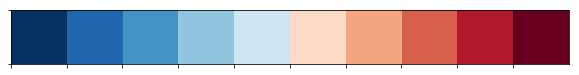

In [32]:
color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
sns.palplot(sns.color_palette(color_scale))

# Loading the data

In [142]:
def load_data(pollutant_ID):
    print('> Loading data...')
    date_vars = ['DatetimeBegin','DatetimeEnd']
    filename = 'data/raw/BE_' + str(pollutant_ID) + '_2013-2015_aggregated_timeseries.csv'
    agg_ts = pd.read_csv(project_dir / filename, sep='\t', parse_dates=date_vars, date_parser=pd.to_datetime)
    return agg_ts

## Data Preparation
#### Data Cleaning
We'll do some basic cleaning of the data:
* Keeping only records with DataAggregationProcss of P1D to have daily data
* Removing records with UnitOfAirPollutionLevel of count
* Removing variables redundant for the visualization
* Removing SamplingPoints which have less than 1000 measurement days
* Inserting missing dates and imputing the AirpollutionLevel with the value of the next valid date

In [143]:
def clean_data(df):
    print('> Cleaning data...')
    df = df.loc[df.DataAggregationProcess=='P1D', :] 
    df = df.loc[df.UnitOfAirPollutionLevel!='count', :]
    ser_avail_days = df.groupby('SamplingPoint').nunique()['DatetimeBegin']
    df = df.loc[df.SamplingPoint.isin(ser_avail_days[ser_avail_days.values >= 1000].index), :]
    vars_to_drop = ['AirPollutant','AirPollutantCode','Countrycode','Namespace','TimeCoverage','Validity','Verification','AirQualityStation',
               'AirQualityStationEoICode','DataAggregationProcess','UnitOfAirPollutionLevel', 'DatetimeEnd', 'AirQualityNetwork',
               'DataCapture', 'DataCoverage']
    df.drop(columns=vars_to_drop, axis='columns', inplace=True)
    
    dates = list(pd.period_range(min(df.DatetimeBegin), max(df.DatetimeBegin), freq='D').values)
    samplingpoints = list(df.SamplingPoint.unique())
    new_idx = []
    for sp in samplingpoints:
        for d in dates:
            new_idx.append((sp, np.datetime64(d)))

    df.set_index(keys=['SamplingPoint', 'DatetimeBegin'], inplace=True)
    df.sort_index(inplace=True)
    df = df.reindex(new_idx)
    df['AirPollutionLevel'] = df.groupby(level=0).AirPollutionLevel.bfill().fillna(0)
    return df

## Plotting the air pollution over time
Loading all of the dates for all samplingpoints would be too heavy for the map. Therefore, we will **resample** the data by taking the last day of each month.

**Remark**: the bin edges that we use in this notebook should normally be applied on (semi-)hourly averages for O3, NO2 and CO. In the datasets we are using in this notebook, we have only daily averages. As this notebook is only to illustrate how to plot time series data on a map, we will continue with the daily averages. On the EEA website you can, however, download hourly averages as well.

In [144]:
def color_coding(poll, bin_edges):    
    idx = np.digitize(poll, bin_edges, right=True)
    return color_scale[idx]

def prepare_data(df, pollutant_ID):
    print('> Preparing data...')
    df = df.reset_index().merge(meta, how='inner', on='SamplingPoint').set_index('DatetimeBegin')
    df = df.loc[:, ['SamplingPoint','Latitude', 'Longitude', 'AirPollutionLevel']]
    df = df.groupby('SamplingPoint', group_keys=False).resample(rule='M').last().reset_index()
    df['color'] = df.AirPollutionLevel.apply(color_coding, bin_edges=pollutants[pollutant_ID]['bin_edges'])
    return df

To show the pollution evolving over time, we will use the **TimestampedGeoJson** [plugin of Folium](https://python-visualization.github.io/folium/plugins.html). This plugin requires geojson input features. In order to convert the data of the dataframe I created a small function **create_geojson_features** that does that.

In [145]:
def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['Longitude'],row['Latitude']]
            },
            'properties': {
                'time': row['DatetimeBegin'].date().__str__(),
                'style': {'color' : row['color']},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 7
                }
            }
        }
        features.append(feature)
    return features

After that the input features are created, we can create a map on which they will be added. The TimestampedGeoJson plugin provides some neat options for the time slider, which are self-explanatory.

In [146]:
def make_map(features):
    print('> Making map...')
    coords_belgium=[50.5039, 4.4699]
    pollution_map = folium.Map(location=coords_belgium, control_scale=True, zoom_start=8)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1M'
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY/MM'
        , time_slider_drag_update=True
    ).add_to(pollution_map)
    print('> Done.')
    return pollution_map

In [147]:
def plot_pollutant(pollutant_ID):
    print('Mapping {} pollution in Belgium in 2013-2015'.format(pollutants[pollutant_ID]['name']))
    df = load_data(pollutant_ID)
    df = clean_data(df)
    df = prepare_data(df, pollutant_ID)
    features = create_geojson_features(df)
    return make_map(features), df

## Sulphur Dioxide

In [148]:
pollution_map, df = plot_pollutant(1)
pollution_map

Mapping Sulphur dioxide pollution in Belgium in 2013-2015
> Loading data...
> Cleaning data...
> Preparing data...
> Creating GeoJSON features...
> Making map...
> Done.


## Particulate Matter

In [151]:
pollution_map, df = plot_pollutant(5)
pollution_map

Mapping Particulate matter < 10 µm pollution in Belgium in 2013-2015
> Loading data...
> Cleaning data...
> Preparing data...
> Creating GeoJSON features...
> Making map...
> Done.


## Ozone

In [152]:
pollution_map, df = plot_pollutant(7)
pollution_map

Mapping Ozone pollution in Belgium in 2013-2015
> Loading data...
> Cleaning data...
> Preparing data...
> Creating GeoJSON features...
> Making map...
> Done.


## Nitrogen Dioxide

In [153]:
pollution_map, df = plot_pollutant(8)
pollution_map

Mapping Nitrogen dioxide pollution in Belgium in 2013-2015
> Loading data...
> Cleaning data...
> Preparing data...
> Creating GeoJSON features...
> Making map...
> Done.


## Carbon Monoxide

In [154]:
pollution_map, df = plot_pollutant(10)
pollution_map

Mapping Carbon monoxide pollution in Belgium in 2013-2015
> Loading data...
> Cleaning data...
> Preparing data...
> Creating GeoJSON features...
> Making map...
> Done.


## Benzene

In [155]:
pollution_map, df = plot_pollutant(20)
pollution_map

Mapping Benzene pollution in Belgium in 2013-2015
> Loading data...
> Cleaning data...
> Preparing data...
> Creating GeoJSON features...
> Making map...
> Done.
